# Probability Integral Transformation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
%matplotlib inline

import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import weibull_min
from scipy.linalg import expm
from progressbar import ProgressBar

/Users/zed/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
class ProbIntegralTransformer(object):
    
    def __init__(self, inv_cdf):
        self.inv_cdf = inv_cdf
        
    def draw(self, n):
        u = np.random.uniform(size=n)
        return np.array([self.inv_cdf(p) for p in u])
    
    def attach_histogram(self, ax, n_sample, bin_width, 
                         truncate=(-np.inf, np.inf), 
                         label='_nolegend_'):
        sample = self.draw(n_sample)
        lb, ub = truncate
        bins = np.arange(max(min(sample), lb), (
            min(max(sample), ub)+bin_width), bin_width)
        ax.hist(sample, bins, normed=1, 
                alpha=0.3, color="grey", label=label)
        return ax, sample
        

In [6]:
def weibull_inv(lamb, k):
    return lambda u: lamb*(-np.log(u))**(1/k)

def weibull_pdf(x_vec, lamb, k):
    return np.array([(k/lamb * (x/lamb) ** (k-1)) * \
        np.exp(-(x/lamb)**k) * (x>=0) for x in x_vec])

def max_brownian_bdge_inv(b, h):
    return lambda u: (b+np.sqrt(b**2-2*np.log(u)*h))/2

def max_brownian_bdge_pdf(x_vec, b, h):
    return np.array([(x>=max(0,b))*np.exp(
        -2*x*(x-b)/h)*(4*x-2*b)/h for x in x_vec])

def cauchy_inv(x0, gamma):
    return lambda u: gamma*np.tan(np.pi*u-np.pi/2)+x0

def cauchy_pdf(x_vec, x0, gamma):
    return np.array([1/(
        np.pi*gamma*(1+((x-x0)/gamma)**2)) for x in x_vec])

def gumbel_inv(mu, beta):
    return lambda u: mu-beta*np.log(-np.log(u))

def gumbel_pdf(x_vec, mu, beta):
    return np.array([(1/beta)*np.exp(
        -(x-mu)/beta-np.exp(-(x-mu)/beta)) for x in x_vec])


## Weibull Distribution
By Wikipedia, the CDF of Weibull distribution is
$$
F_X(x) = \begin{cases}
1-e^{-(x/\lambda)^k} & x\geq 0 \\[5pt]
0 & x<0
\end{cases}
$$
And the inverse CDF is
$$
F^{-1}(u) = \lambda (-\log(1-u))^{\frac{1}{k}} ,~~u\in (0,1)
$$

| 4 Elapsed Time: 0:00:08                                                      


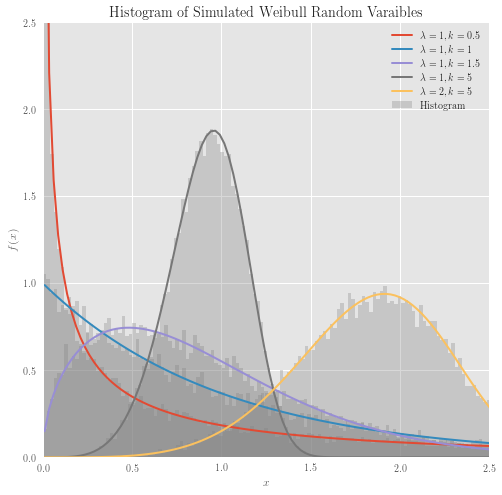

In [7]:
weibull_params = [
    (1,0.5), (1, 1), (1, 1.5), (1, 5), (2, 5)]

bar = ProgressBar()
fig, ax = plt.subplots(1, 1, figsize=(8,8))

for i, param in bar(enumerate(weibull_params)):
    weibull_sampler = ProbIntegralTransformer(
        weibull_inv(*param))
    label = 'Histogram' if i==4 else '_nolegend_' 
    ax, sample = weibull_sampler.attach_histogram(
        ax, 20000, 0.02, label=label)
    x = np.linspace(0.01, 2.5, 100)
    ax.plot(x, weibull_pdf(x, *param), linewidth=2, 
            label=r'$\lambda={}, k={}$'.format(*param))
    
ax.set_xlim((0,2.5))
ax.set_ylim((0,2.5))
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x)$')
ax.set_title('Histogram of Simulated Weibull Random Varaibles')
_ = ax.legend()

## Distribution of Maximum of BM
The inverse CDF of the given distribution is
$$
F^{-1}(u) = \frac{b+\sqrt{b^2 - \frac{2\log(u)}{h}}}{2},~~u\in (0,1)
$$
It's easy to see that $F^{-1}(u) \geq \max(0,b)$, since $\log(u) < 0$ with $0<u<1$. We can sample $X$ with this formula.

| 4 Elapsed Time: 0:00:01                                                      


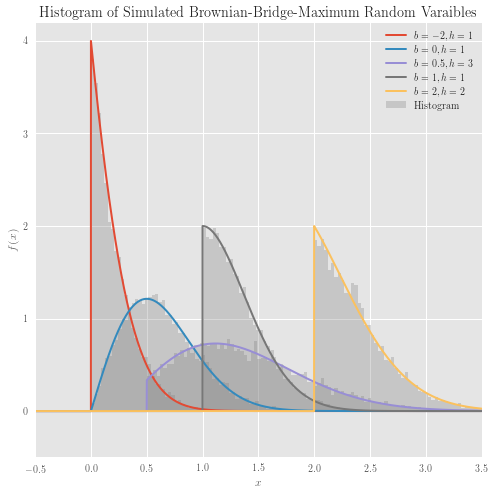

In [8]:
bb_params = [(-2,1), (0,1), (0.5,3), (1,1), (2,2)]
bar = ProgressBar()
fig, ax = plt.subplots(1, 1, figsize=(8,8))
for i, param in bar(enumerate(bb_params)):
    max_brownian_bdge_sampler = ProbIntegralTransformer(
        max_brownian_bdge_inv(*param))
    label = 'Histogram' if i==4 else '_nolegend_'
    ax, sample = max_brownian_bdge_sampler.attach_histogram(
        ax, 10000, 0.03, label=label)
    x = np.linspace(-0.5, 4, 10000)
    ax.plot(x, max_brownian_bdge_pdf(x, *param), linewidth=2,
            label=r'$b={}, h={}$'.format(*param))
    
ax.set_xlim((-0.5,3.5))
ax.set_ylim((-0.5,4.2))
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x)$')
ax.set_title('Histogram of Simulated Brownian-Bridge-Maximum Random Varaibles')
_ = ax.legend()

## Cauchy Distribution
The inverse CDF of Cauchy distribution is
$$
F^{-1}(u) = \tan(\pi u-\frac{\pi}{2}),~~u\in (0,1)
$$
We sample $X$ with this formula.

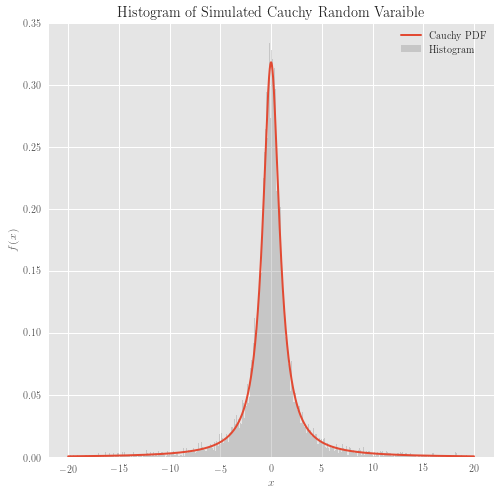

In [9]:
x = np.linspace(-20, 20, 10000)
fig, ax = plt.subplots(1, 1, figsize=(8,8))
cauchy_sampler = ProbIntegralTransformer(cauchy_inv(0, 1))
ax, sample = cauchy_sampler.attach_histogram(
    ax, 10000, 0.1, truncate=(-20,20), label="Histogram")
ax.plot(x, cauchy_pdf(x, 0, 1), 
        linewidth=2, label="Cauchy PDF")
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x)$')
ax.set_title('Histogram of Simulated Cauchy Random Varaible')
_ = ax.legend()


## Standard Gumbel Distribution
(i) We sample with the inverse CDF:
$$
F^{-1}(u) = -\log(-\log(u)),~~u\in (0,1)
$$
(ii) As instructed, let $Y_n:=M_n-a_n$, the CDF of $Y_n=\max(X_1, ..., X_n)-a_n$ is
$$
\begin{split}
F_Y(y) &= P(M\leq y+a_n) = P\left(\bigcap_{i=1}^n(X_i \leq y+a_n) \right) \\
&= \prod_{i=1}^n P(X_i \leq y+a_n) \\
&= \exp(-ne^{-(y+a_n)})
\end{split}
$$
If $Y_n$ is to be of standard Gumbel distributed, we need $F_Y(y) = \exp(-ne^{-(y+a_n)})=\exp(-e^{-y})$ $\Rightarrow$ $a_n = \log n$.

This implies that $\{M_n\}$ grows in a rate of $\log n$.

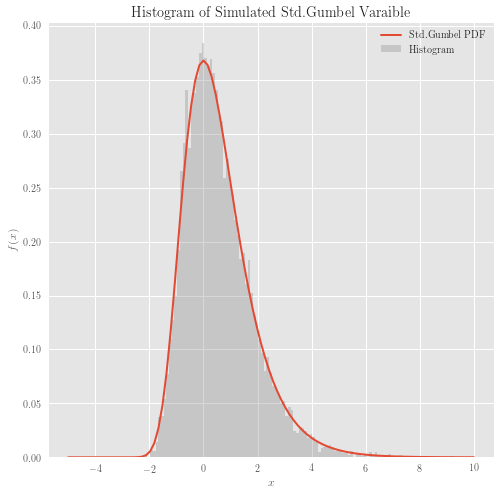

In [10]:
x = np.linspace(-5, 10, 100)
fig, ax = plt.subplots(1, 1, figsize=(8,8))
std_gumbel_sampler = ProbIntegralTransformer(gumbel_inv(0, 1))
ax, sample = std_gumbel_sampler.attach_histogram(
    ax, 10000, 0.1, label="Histogram")
ax.plot(x, gumbel_pdf(x, 0, 1), 
        linewidth=2, label="Std.Gumbel PDF")
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x)$')
ax.set_title('Histogram of Simulated Std.Gumbel Varaible')
_ = ax.legend()

# Bond Rating Simulation

In [2]:
Q = np.array([
    [-.1154, .1019, .0083, .0020, .0031, 0, 0, 0],
    [.0091, -.1043, .0787, .0105, .0030, .0030, 0, 0],
    [.0010, .0309, -.1172, .0688, .0107, .0048, 0, .0010],
    [.0007, .0047, .0713, -.1711, .0701, .0174, .0020, .0049],
    [.0005, .0025, .0089, .0813, -.2530, .1181, .0144, .0273],
    [0, .0021, .0034, .0073, .0568, -.1928, .0479, .0753],
    [0,0,.0142, .0142, .0250, .0928, -.4318, .2856],
    [0, 0, 0, 0, 0, 0, 0, 0]
])

M = np.array([
    [0,.8838, .0720, .0173, .0269, 0, 0, 0],
    [.0872, 0, .7545, .1007, .0288, .0288, 0,0],
    [.0085, .2637, 0, .5870, .0913, .0410, 0, .0085],
    [.0041, .0275, .4167, 0, .4097, .1017, .0117, .0286],
    [.0020, .0099, .0352, .3213, 0, .4668, .0569, .1079],
    [0, .0109, .0176, .0379, .2946, 0, .2484, .3906],
    [0, 0, .0329, .0329, .0579, .2149, 0, .6614],
    [0,0,0,0,0,0,0,1]
])



In [6]:
import numpy as np
np.zeros((10,3))

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [21]:
a = np.array([[0,1],[2,3], [4,5]])
a[[0,1,1,1,0],1]

array([1, 3, 3, 3, 1])

In [18]:
import operator as op
pmf = [[7, 4/24], [3,12/24], [16, 20/24]]
for i in range(3): pmf[i][1]*=2 
pmf

[[7, 0.3333333333333333], [3, 1.0], [16, 1.6666666666666667]]

In [3]:
class MarkovAliasTable(object):
    def __init__(self, transition_matrix):
        self.n = len(transition_matrix)
        self.transition_matrix = transition_matrix
        table_dim = (self.n, self.n-1)
        self.prob = np.zeros(table_dim)
        self.values = np.zeros(table_dim, dtype=np.int32)
        self.alias = np.zeros(table_dim, dtype=np.int32)
        self.__make_table()
    
    def __make_table(self):
        for i, row in enumerate(self.transition_matrix):
            pmf = sorted([list(t) for t in zip(range(self.n), (
                self.n-1)*row)], key=lambda t:-t[1])
            for j in range(self.n-1):
                (state, p), alias = pmf[-1], pmf[0][0]
                self.prob[i,j] = p 
                self.values[i,j] = state
                self.alias[i,j] = alias
                pmf[0][1] -= 1-p
                pmf.pop()
                pmf = sorted(pmf, key=lambda t:-t[1])
                
    def draw(self, init_state):
        u = np.random.uniform()
        v = (self.n-1)*u
        i = int(np.ceil(v))
        w = i-v
        if w<=self.prob[init_state,i-1]:
            return self.values[init_state,i-1]
        else: return self.alias[init_state,i-1]
        
    def draw_path(self, clock_model, T, init_state):
        clock, state = 0, init_state
        while clock <= T:
            dt = clock_model(state)     
            clock += dt
            if clock >= T: break
            state = self.draw(state)
        return state
    
    def estimate_prob(self, clock_model, T, init_state, n_paths):
        est = np.zeros(self.n)
        for _ in range(n_paths):
            final = self.draw_path(clock_model, T, init_state)
            est[final] += 1
        est /= n_paths
        return est
    
    def estimate_trans_matrix(self, clock_model, T, n_paths):
        bar = ProgressBar()
        est = np.zeros((self.n, self.n))
        for i in bar(range(self.n)):
            est[i,:] = self.estimate_prob(
                clock_model, T, i, n_paths)
        return est

In [4]:
def exponential_holding_time(state):
    exp_rates = [.1154, .1043, .1172, .1711, .2530, .1929, .4318, .0001]
    return np.random.exponential(1/exp_rates[state])

def gamma_holding_time(state):
    gamma_rates = [.1154, .1043, .1172, .1711, .2530, .1929, .4318, .0001]
    return 0.5*np.random.gamma(2,1/gamma_rates[state])

## $\tau \sim$ Exponential($\lambda$) Case

In [50]:
T, n_paths = 5, 1000000
credit_rating_names = ['AAA','AA','A','BBB','BB','B','C','D']
credit_rating_simulator = MarkovAliasTable(M)
P_hat = credit_rating_simulator.estimate_trans_matrix(
    exponential_holding_time, T, n_paths)
df_p_hat = pd.DataFrame(
    P_hat, index=credit_rating_names, 
    columns=credit_rating_names)
df_p = pd.DataFrame(
    expm(Q*T), index=credit_rating_names, 
    columns=credit_rating_names)

100% (8 of 8) |###########################| Elapsed Time: 0:01:08 Time: 0:01:08


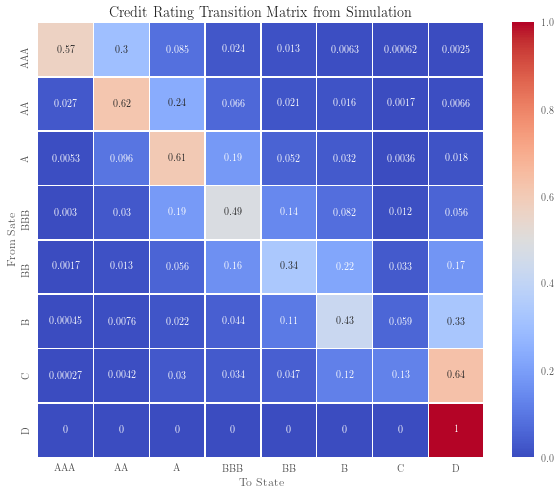

In [43]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    df_p_hat, annot=True, 
    cmap="coolwarm",
    linewidths=.5, ax=ax)
ax.set_xlabel('To State')
ax.set_ylabel('From Sate')
ax.set_title('Credit Rating Transition Matrix from Simulation')

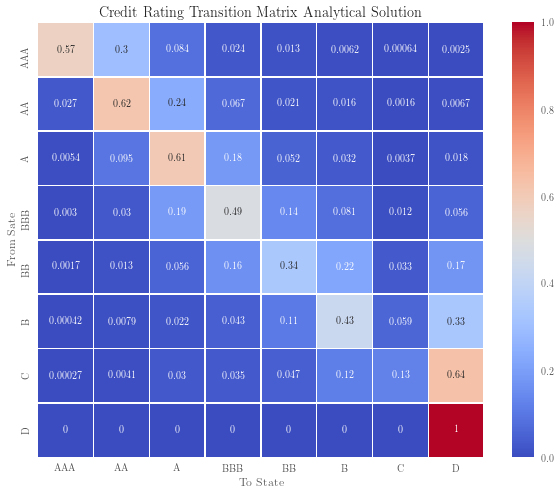

In [7]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    df_p, annot=True, 
    cmap="coolwarm",
    linewidths=.5, ax=ax)
ax.set_xlabel('To State')
ax.set_ylabel('From Sate')
ax.set_title('Credit Rating Transition Matrix Analytical Solution')

In [51]:
# the exact solution calculated by exp(QT)
df_p

,AAA,AA,A,BBB,BB,B,C,D
AAA,0.568493,0.300650,0.084463,0.024180,0.012511,0.006203,0.000642,0.002477
AA,0.027357,0.619661,0.240257,0.066931,0.021034,0.016447,0.001624,0.006681
A,0.005355,0.095353,0.608999,0.184625,0.052265,0.031680,0.003656,0.018066
BBB,0.003012,0.029545,0.190720,0.486208,0.141783,0.081408,0.011601,0.055723
BB,0.001745,0.013086,0.056422,0.162734,0.338476,0.220439,0.033337,0.173761
B,0.000421,0.007887,0.021583,0.043201,0.107411,0.430096,0.059091,0.330310
C,0.000274,0.004136,0.029672,0.034582,0.046817,0.120885,0.127722,0.635913
D,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [52]:
# The estimate via Monte Carlo simulation
df_p_hat

,AAA,AA,A,BBB,BB,B,C,D
AAA,0.568884,0.300374,0.084725,0.024238,0.012518,0.006168,0.000661,0.002432
AA,0.027497,0.619337,0.240777,0.066687,0.021087,0.016363,0.001625,0.006627
A,0.005361,0.094974,0.609128,0.184794,0.052276,0.031665,0.003685,0.018117
BBB,0.002882,0.029460,0.190791,0.486971,0.141442,0.081263,0.011550,0.055641
BB,0.001735,0.013023,0.055963,0.163478,0.338321,0.219840,0.033213,0.174427
B,0.000415,0.007838,0.021465,0.043599,0.107460,0.429637,0.058966,0.330620
C,0.000250,0.004152,0.029692,0.034608,0.046714,0.120994,0.128291,0.635299
D,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [53]:
# Standard error
se_p_hat = np.sqrt(P_hat*(1-P_hat)/n_paths)
df_se_p_hat = pd.DataFrame(
    se_p_hat, index=credit_rating_names, 
    columns=credit_rating_names)
df_se_p_hat

,AAA,AA,A,BBB,BB,B,C,D
AAA,0.000495,0.000458,0.000278,0.000154,0.000111,0.000078,0.000026,0.000049
AA,0.000164,0.000486,0.000428,0.000249,0.000144,0.000127,0.000040,0.000081
A,0.000073,0.000293,0.000488,0.000388,0.000223,0.000175,0.000061,0.000133
BBB,0.000054,0.000169,0.000393,0.000500,0.000348,0.000273,0.000107,0.000229
BB,0.000042,0.000113,0.000230,0.000370,0.000473,0.000414,0.000179,0.000379
B,0.000020,0.000088,0.000145,0.000204,0.000310,0.000495,0.000236,0.000470
C,0.000016,0.000064,0.000170,0.000183,0.000211,0.000326,0.000334,0.000481
D,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [54]:
# sanity check
# It appears that most of the absolute differences between
# exact and simulated P matrix are smaller 2 standard errors.
np.abs(P_hat - expm(Q*T)) <=2* se_p_hat

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True, False,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]], dtype=bool)

## $\tau \sim$ $\frac{1}{2}\Gamma(2, \lambda_i)$ Case

In [38]:
T = 5
credit_rating_names = ['AAA','AA','A','BBB','BB','B','C','D']
credit_rating_simulator = MarkovAliasTable(M)
P_hat_gamma = credit_rating_simulator.estimate_trans_matrix(
    gamma_holding_time, T, n_paths)
df_p_hat_gamma = pd.DataFrame(
    P_hat_gamma, index=credit_rating_names, 
    columns=credit_rating_names)

100% (8 of 8) |###########################| Elapsed Time: 0:01:18 Time: 0:01:18


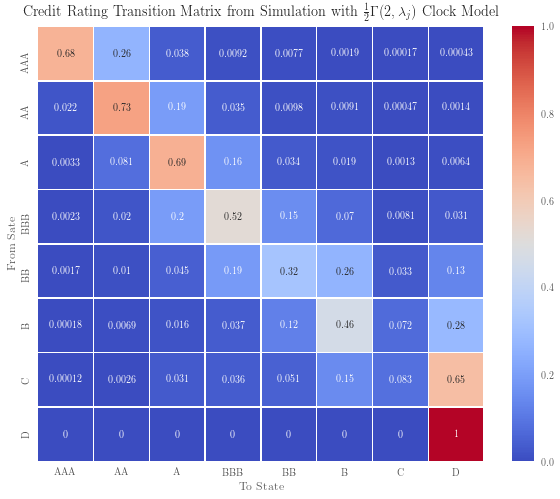

In [39]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    df_p_hat_gamma, annot=True, 
    cmap="coolwarm",
    linewidths=.5, ax=ax)
ax.set_xlabel('To State')
ax.set_ylabel('From Sate')
ax.set_title('Credit Rating Transition Matrix from Simulation '
             +r'with $\frac{1}{2}\Gamma(2,\lambda_j)$ Clock Model')

In [40]:
# The estimate via Monte Carlo simulation
df_p_hat_gamma

,AAA,AA,A,BBB,BB,B,C,D
AAA,0.680262,0.262295,0.038076,0.009162,0.007715,0.001891,0.000168,0.000431
AA,0.022481,0.727664,0.193886,0.035217,0.009832,0.009075,0.000467,0.001378
A,0.003319,0.081349,0.690421,0.164152,0.034408,0.018589,0.001320,0.006442
BBB,0.002329,0.019638,0.195105,0.520959,0.153372,0.069866,0.008118,0.030613
BB,0.001662,0.009990,0.045198,0.190208,0.322348,0.264006,0.033377,0.133211
B,0.000180,0.006854,0.016250,0.036910,0.123126,0.463220,0.071753,0.281707
C,0.000124,0.002552,0.031314,0.035601,0.050524,0.149445,0.082540,0.647900
D,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


We can see that with $\tau \sim 0.5\Gamma(2,\lambda_j)$, the diagonal of the transition matrix has more probability mass, which means that the credit rating is more "stable" than the case in which we employ the exponentential clock model.

In [56]:
# The standard error
se_p_hat_gamma = np.sqrt(P_hat_gamma*(1-P_hat_gamma)/n_paths)
df_se_p_hat_gamma = pd.DataFrame(
    se_p_hat_gamma, index=credit_rating_names, 
    columns=credit_rating_names)
df_se_p_hat_gamma

,AAA,AA,A,BBB,BB,B,C,D
AAA,0.000466,0.000440,0.000191,0.000095,0.000087,0.000043,0.000013,0.000021
AA,0.000148,0.000445,0.000395,0.000184,0.000099,0.000095,0.000022,0.000037
A,0.000058,0.000273,0.000462,0.000370,0.000182,0.000135,0.000036,0.000080
BBB,0.000048,0.000139,0.000396,0.000500,0.000360,0.000255,0.000090,0.000172
BB,0.000041,0.000099,0.000208,0.000392,0.000467,0.000441,0.000180,0.000340
B,0.000013,0.000083,0.000126,0.000189,0.000329,0.000499,0.000258,0.000450
C,0.000011,0.000050,0.000174,0.000185,0.000219,0.000357,0.000275,0.000478
D,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Gaussian RV Generator

In [290]:
def poor_mans(size):
    return np.array([sum(np.random.uniform(
        size=12))-6 for _ in range(size)])

## Python's Normal Generator

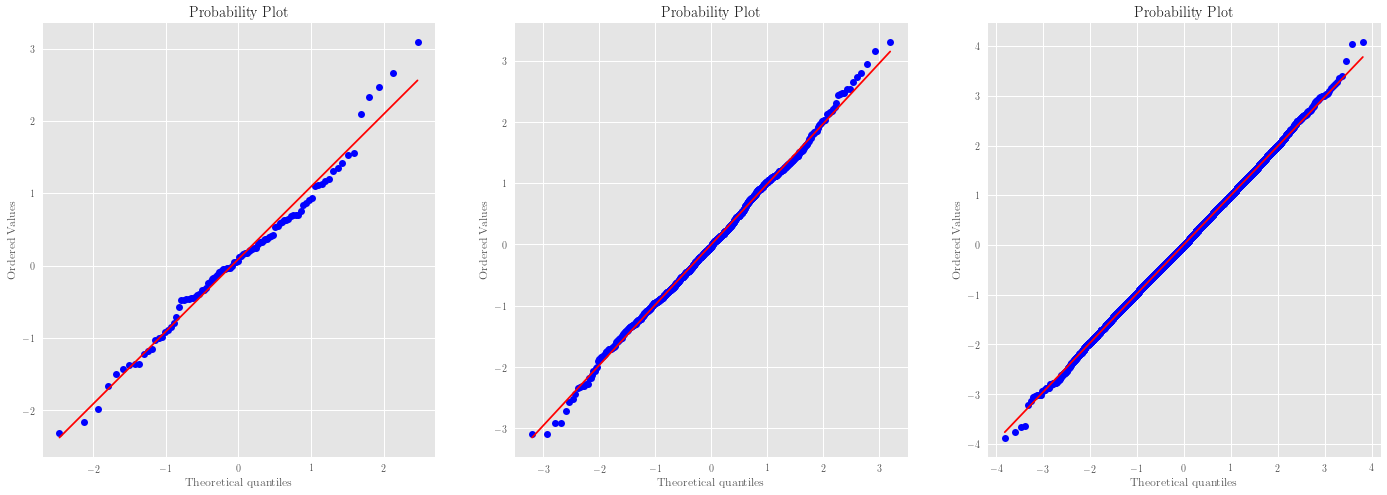

In [295]:
f, axes = plt.subplots(1,3,figsize=(24, 8))
for j in range(3):
    normal_sample = np.random.normal(size=10**(j+2))
    qq = stats.probplot(
        normal_sample, dist="norm", plot=axes[j])

## "Poor man's" Normal Generator

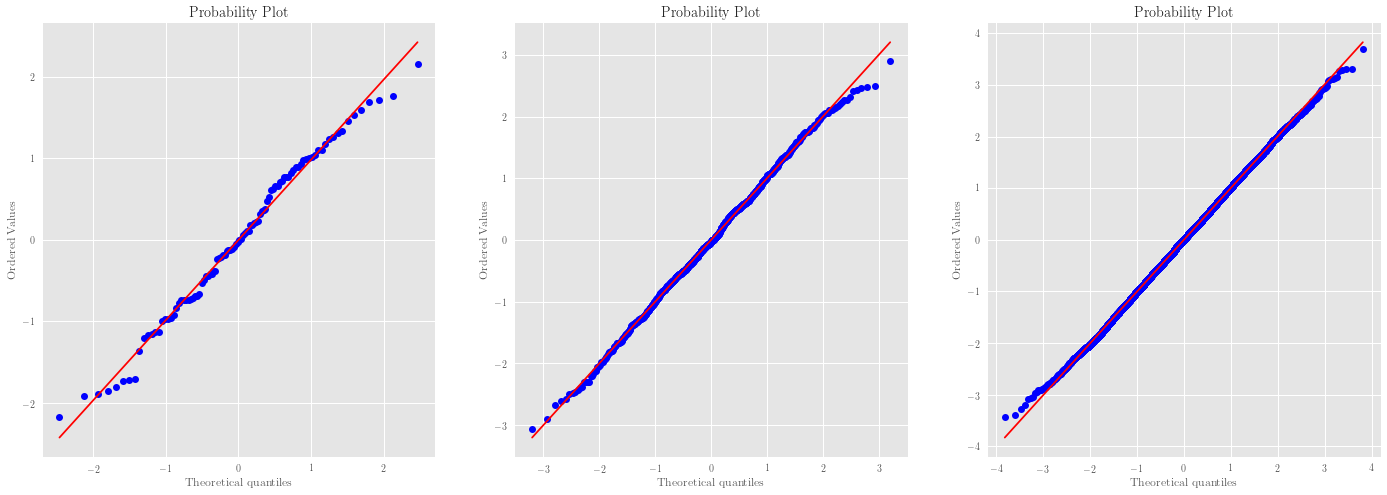

In [297]:
f, axes = plt.subplots(1,3,figsize=(24, 8))
for j in range(3):
    normal_sample = poor_mans(size=10**(j+2))
    qq = stats.probplot(
        normal_sample, dist="norm", plot=axes[j])

Poor man's normal generator actually seems to do a good job.